In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)

In [2]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 0


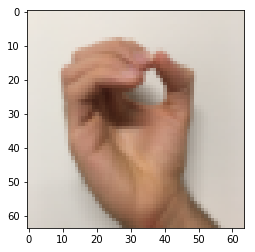

In [3]:
# Example of a picture
index = 1
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

As usual you flatten the image dataset, then normalize it by dividing by 255. On top of that, you will convert each label to a one-hot vector as shown in Figure 1. Run the cell below to do so.

In [4]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


### 1 - Create placeholders

In [5]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    """

    X = tf.placeholder(dtype=tf.float32, shape=[n_x, None])
    Y = tf.placeholder(dtype=tf.float32, shape=[n_y, None])
    
    return X, Y

### 2 - Initializing the parameters


In [6]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   
    W1_init = tf.contrib.layers.xavier_initializer(seed=1)
    W1 = tf.get_variable(name="W1", shape=[25, 12288], initializer=W1_init, regularizer=tf.contrib.layers.l2_regularizer(scale=0.001))
    b1 = tf.get_variable(name="b1", shape=[25,1], initializer=tf.zeros_initializer())
    
    W2_init = tf.contrib.layers.xavier_initializer(seed=1)
    W2 = tf.get_variable(name="W2", shape=[12, 25], initializer=W2_init, regularizer=tf.contrib.layers.l2_regularizer(scale=0.001))
    b2 = tf.get_variable(name="b2", shape=[12,1], initializer=tf.zeros_initializer())
    
    W3_init = tf.contrib.layers.xavier_initializer(seed=1)
    W3 = tf.get_variable(name="W3", shape=[6, 12], initializer=W3_init, regularizer=tf.contrib.layers.l2_regularizer(scale=0.001))
    b3 = tf.get_variable(name="b3", shape=[6,1], initializer=tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

### 3 - Forward propagation in tensorflow 

In [7]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    epsilon = 1e-3
    
    Z1 = tf.add(tf.matmul(W1,X), b1)                                             # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                             # A1 = relu(Z1)
    
    Z2 = tf.add(tf.matmul(W2,A1), b2)                                              # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                              # A2 = relu(Z2)
    
    Z3 = tf.add(tf.matmul(W3,A2), b3)                                              # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

### 4 - Compute cost

In [8]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

### 5 - Building the model

In [9]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 3000, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 1.855702
Cost after epoch 100: 1.016458
Cost after epoch 200: 0.733102
Cost after epoch 300: 0.572940
Cost after epoch 400: 0.468774
Cost after epoch 500: 0.381021
Cost after epoch 600: 0.313822
Cost after epoch 700: 0.254158
Cost after epoch 800: 0.203829
Cost after epoch 900: 0.166421
Cost after epoch 1000: 0.141486
Cost after epoch 1100: 0.107580
Cost after epoch 1200: 0.086270
Cost after epoch 1300: 0.059371
Cost after epoch 1400: 0.052228
Cost after epoch 1500: 0.033770
Cost after epoch 1600: 0.025227
Cost after epoch 1700: 0.017898
Cost after epoch 1800: 0.014067
Cost after epoch 1900: 0.008593
Cost after epoch 2000: 0.006591
Cost after epoch 2100: 0.005560
Cost after epoch 2200: 0.003843
Cost after epoch 2300: 0.003536
Cost after epoch 2400: 0.002554
Cost after epoch 2500: 0.002527
Cost after epoch 2600: 0.001862
Cost after epoch 2700: 0.001619
Cost after epoch 2800: 0.001396
Cost after epoch 2900: 0.001369


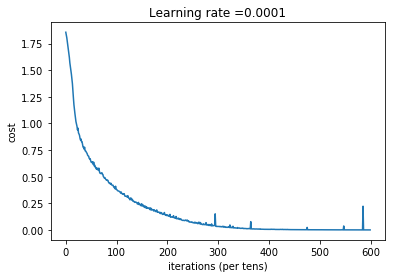

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 0.733333


In [10]:
parameters = model(X_train, Y_train, X_test, Y_test)